In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn lightgbm kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdrokonuzzaman040","key":"c1485ad4d97df24715525056550cc098"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d avinemmatty/theft-data
!unzip theft-data.zip

Dataset URL: https://www.kaggle.com/datasets/avinemmatty/theft-data
License(s): unknown
100% 4.79M/4.79M [00:00<00:00, 44.5MB/s]
100% 4.79M/4.79M [00:00<00:00, 44.3MB/s]
Archive:  theft-data.zip
  inflating: Electricity_Theft_Data.csv  


In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv("Electricity_Theft_Data.csv")  # Replace with the correct file name
print(data.head())
print(data.info())

        CONS_NO  01-01-15  02-01-15  03-01-15  04-01-15  05-01-15  06-01-15  \
0           NaN      1.00      2.00      3.00      4.00      5.00      6.00   
1  8.546920e+09      0.00      0.00      0.00      0.00      0.00      0.00   
2  6.177183e+08      1.12      1.73      3.34      2.77      3.50      2.86   
3  7.222500e+09       NaN       NaN       NaN       NaN       NaN       NaN   
4  7.134080e+09      1.58      3.65      2.54      4.28      1.62      1.39   

   07-01-15  08-01-15  09-01-15  ...  23-12-15  24-12-15  25-12-15  26-12-15  \
0      7.00      8.00      9.00  ...    357.00    358.00    359.00    360.00   
1      0.00      0.00      0.00  ...      0.00      0.00      0.00      0.00   
2      1.25      1.12      1.51  ...     17.31     15.95     17.00     32.05   
3       NaN       NaN       NaN  ...      0.00      0.00      0.00      0.00   
4      2.33      1.78      1.80  ...      4.17      7.95      8.84      2.20   

   27-12-15  28-12-15  29-12-15  30-12-15  3

# Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, roc_curve, auc
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load the Dataset


In [ ]:
def optimize_dataframe(df):
    """Optimize memory usage by downcasting numeric columns and converting objects to categories."""
    for col in df.select_dtypes(include=['float']):
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int']):
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']):
        if df[col].nunique() / len(df) < 0.5:  # Convert likely categorical columns
            df[col] = df[col].astype('category')
    return df

# Load dataset in chunks and optimize memory usage
dataset_path = 'Electricity_Theft_Data.csv'  # Replace with your file path
chunk_size = 10000
chunks = []

for chunk in pd.read_csv(dataset_path, chunksize=chunk_size):
    optimized_chunk = optimize_dataframe(chunk)
    chunks.append(optimized_chunk)

# Combine all chunks into a single DataFrame
data = pd.concat(chunks, ignore_index=True)

# Display the memory usage after optimization
print(data.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9957 entries, 0 to 9956
Columns: 367 entries, CONS_NO to CHK_STATE
dtypes: float32(356), float64(11)
memory usage: 14.4 MB
None


# Step 2: Data Preprocessing


In [ ]:
# Fill missing values
data.fillna(0, inplace=True)

# Convert target variable to categorical
target_column = 'CHK_STATE'  # Replace with the actual target column name
data[target_column] = data[target_column].astype('category')

# Drop unnecessary columns if applicable
if 'CONS_NO' in data.columns:
    data.drop(['CONS_NO'], axis=1, inplace=True)

# Separate features and target
X = data.drop([target_column], axis=1)
y = data[target_column].astype('int')

# Step 3: Data Visualization (Class Distribution)

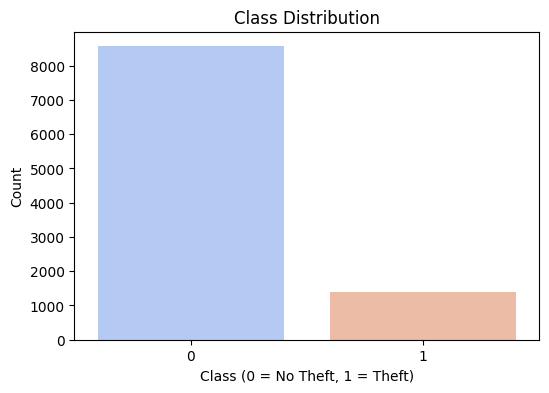

In [ ]:
# Step 3: Data Visualization (Class Distribution)
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Class Distribution")
plt.xlabel("Class (0 = No Theft, 1 = Theft)")
plt.ylabel("Count")
plt.show()

# Step 4: Handle Class Imbalance with SMOTE


In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 5: Train-Test Split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

# Initialize Models

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42, device_type='gpu'),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Hyperparameter grids for each model

In [ ]:
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [20, 31],
        'max_depth': [5, 7]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [5, 7]
    }
}

# Train and Evaluate Models

In [ ]:
results = []

for name, model in models.items():
    print(f"Training {name}...")
    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        scoring='roc_auc',
        n_iter=10,
        cv=3,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score']
    })

Training Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Training Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


# Compare Results

In [ ]:
results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df)

# Visualize Model Comparison

In [ ]:
results_df.set_index('Model')[['Accuracy', 'ROC-AUC', 'F1-Score']].plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()


# Save Results

In [ ]:
results_df.to_csv('model_comparison_results.csv', index=False)
print("Model comparison results saved to 'model_comparison_results.csv'.")